In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib as ml
import time
from IPython import display
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings('ignore')

In [2]:
R = 8.3144

class phasereg(object):
    '''
    A phase in a binary system. A simple class to hold the constants,
    and plot the phase diagram at a specified temperature and reference.
    
    carry = an array containing the constants [A,B,C,D,E,F], which are
    detailed below.
    '''
    def __init__(self,carry):
        self._carry = carry
        
    def C(self):
        return self._carry
    
    def plotPD(self,T,ref):
        X = np.linspace(0.001,0.999,1001)
        G = GReg(X,T,self.C(),ref)
        plt.plot(X,G)
        plt.xlim([0.,1.])
        plt.xlabel('Concentration')
        plt.ylabel('DG')

def GReg(x,T,const,ref):
    '''
    Function to calculate the free energy of a given phase at a
    specified temperature and reference.
    
    x = float, concentration of component B, taking a value from 0 to 1.
    T = float, temperature
    refA = boolean, flag for whether to reference component A as zero
    refB = boolean, flag for whether to reference component B as zero
    '''
    A = const[0] #DGmelting
    B = const[1]
    C = const[2]
    D = const[3]
    E = const[4]
    GmA = A+B*T
    GmB = C+D*T
    refA = ref[0]
    refB = ref[1]
    
    if refA == True:
        if refB == True:
            out = E*(1-x)*x+R*T*((1-x)*np.log(1-x)+x*np.log(x))
        else:
            out = GmB*x+E*(1-x)*x+R*T*((1-x)*np.log(1-x)+x*np.log(x))
    else:
        if refB == True:
            out = GmA*(1-x)+E*(1-x)*x+R*T*((1-x)*np.log(1-x)+x*np.log(x))
        else:
            out = GmA*(1-x)+GmB*x+E*(1-x)*x+R*T*((1-x)*np.log(1-x)+x*np.log(x))
    return out

def fun(var,A1,A2,B1,B2,C1,C2,D1,D2,E,F,T):
    '''
    Function specifying system of simultaneous equations which must be satisfied.
    '''
    xB1 = var[0]
    xB2 = var[1]
    GmA1 = A1+B1*T
    GmB1 = C1+D1*T
    GmA2 = A2+B2*T
    GmB2 = C2+D2*T
    G1 = GmA1*(1.-xB1)+GmB1*xB1+R*T*((1.-xB1)*np.log(1.-xB1)+xB1*np.log(xB1))+E*(1.-xB1)*xB1
    G2 = GmA2*(1.-xB2)+GmB2*xB2+R*T*((1.-xB2)*np.log(1.-xB2)+xB2*np.log(xB2))+F*(1.-xB2)*xB2
    dG1 = GmB1-GmA1+R*T*np.log(xB1/(1.-xB1))+E*(1.-2.*xB1)
    dG2 = GmB2-GmA2+R*T*np.log(xB2/(1.-xB2))+F*(1.-2.*xB2)
    out = [abs(((G2-G1)/(xB2-xB1))-dG2)]
    out.append(abs(dG2-dG1))
    return out

def getcomtan(phase1,phase2,T,xguess,p1ref):
    '''
    Main calling function to calculate the concentrations corresponding to the
    equilibrium phase boundaries.
    '''
    refA = p1ref[0]
    refB = p1ref[1]
    p2ref = [not refA,not refB]
    
    if refA == True:
        A1 = 0
        B1 = 0
        A2 = phase2.C()[0]
        B2 = phase2.C()[1]
        if refB == True:
            C1 = 0
            D1 = 0
            C2 = phase2.C()[2]
            D2 = phase2.C()[3]
        else:
            C1 = phase1.C()[2]
            D1 = phase1.C()[3]
            C2 = 0
            D2 = 0
    else:
        A1 = phase1.C()[0]
        B1 = phase1.C()[1]
        A2 = 0
        B2 = 0
        if refB == True:
            C1 = 0
            D1 = 0
            C2 = phase2.C()[2]
            D2 = phase2.C()[3]
        else:
            C1 = phase1.C()[2]
            D1 = phase1.C()[3]
            C2 = 0
            D2 = 0
    E = phase1.C()[4]
    F = phase2.C()[4]
    
    xB = fsolve(fun,x0=xguess,args=(A1,A2,B1,B2,C1,C2,D1,D2,E,F,T),xtol=1e-12,maxfev=1000,full_output=True,col_deriv=True)
    #print(xB)
    x1 = xB[0][0]
    x2 = xB[0][1]
    success = xB[2]
    slope12 = (GReg(x2,T,phase2.C(),p1ref) - GReg(x1,T,phase1.C(),p2ref))/(x2-x1)
    return([x1,x2,slope12,success])

### Define phases

e.g. phase = phasereg([A,B,C,D,E])

where $\Delta\overline{G}_n = X_A\overline{G}^\circ_{A} + X_B\overline{G}^\circ_{B} + R\,T\left(X_A \ln X_A + X_B \ln X_B\right) + \Omega_n X_A X_B$

with

$\overline{G}^\circ_{A} = A + B\,T$, $\overline{G}^\circ_{B} = C + D\,T$, and $\Omega = E$.

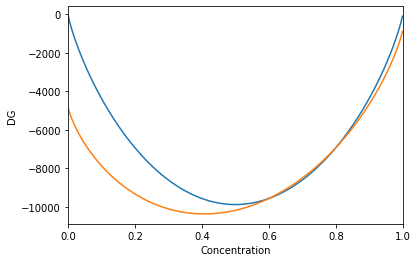

In [3]:
phase1 = phasereg([-8000,10,-12000,10,-10000]) #need to flip sign of component ref G constants
phase2 = phasereg([8000,-10,12000,-10,0])

phases = [phase1, phase2]

#plot the free energy curves
phase1.plotPD(1280,[1,1]) #make sure the ref values (0 or 1)
phase2.plotPD(1280,[0,0]) #are opposite between phase 1 and 2

### Estimate initial guesses

Result from first pass: [0.6169298541452691, 0.5794280680697443, 3410.111914559386, 1]
Result from second pass: [0.7875537723584854, 0.8137828192149363, 15695.24471939983, 1]


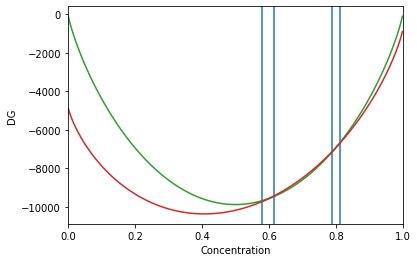

In [4]:
T = 1280

guess_low = [0.6,0.5] #[phase 1 comp, phase 2 comp]
guess_hi = [0.7,0.8]

p1ref = [1,1]
p2ref = [not p1ref[0],not p1ref[1]]

result = getcomtan(phases[0],phases[1],T,guess_low,p1ref)
print('Result from first pass:',result)

if result[3] == 1: #if a solution was found
    Xval = np.array([result[0],result[1]])

    G1 = GReg(Xval[0],T,phase1.C(),p1ref)
    G2 = GReg(Xval[0],T,phase2.C(),p2ref)
    if G1 < G2:
        plt.plot(Xval,[G1,GReg(Xval[1],T,phase2.C(),p2ref)])
    else:
        plt.plot(Xval,[G2,GReg(Xval[1],T,phase1.C(),p1ref)])
    plt.axvline(x=Xval[0])
    plt.axvline(x=Xval[1])

result = getcomtan(phases[0],phases[1],T,guess_hi,p1ref)
print('Result from second pass:',result)
if result[3] == 1:
    Xval = np.array([result[0],result[1]])

    G1 = GReg(Xval[0],T,phase1.C(),p1ref)
    G2 = GReg(Xval[0],T,phase2.C(),p2ref)
    if G1 < G2:
        plt.plot(Xval,[G1,GReg(Xval[1],T,phase2.C(),p2ref)])
    else:
        plt.plot(Xval,[G2,GReg(Xval[1],T,phase1.C(),p1ref)])
    plt.axvline(x=Xval[0])
    plt.axvline(x=Xval[1])

phase1.plotPD(T,p1ref)
phase2.plotPD(T,p2ref)

### Construct Phase Diagram

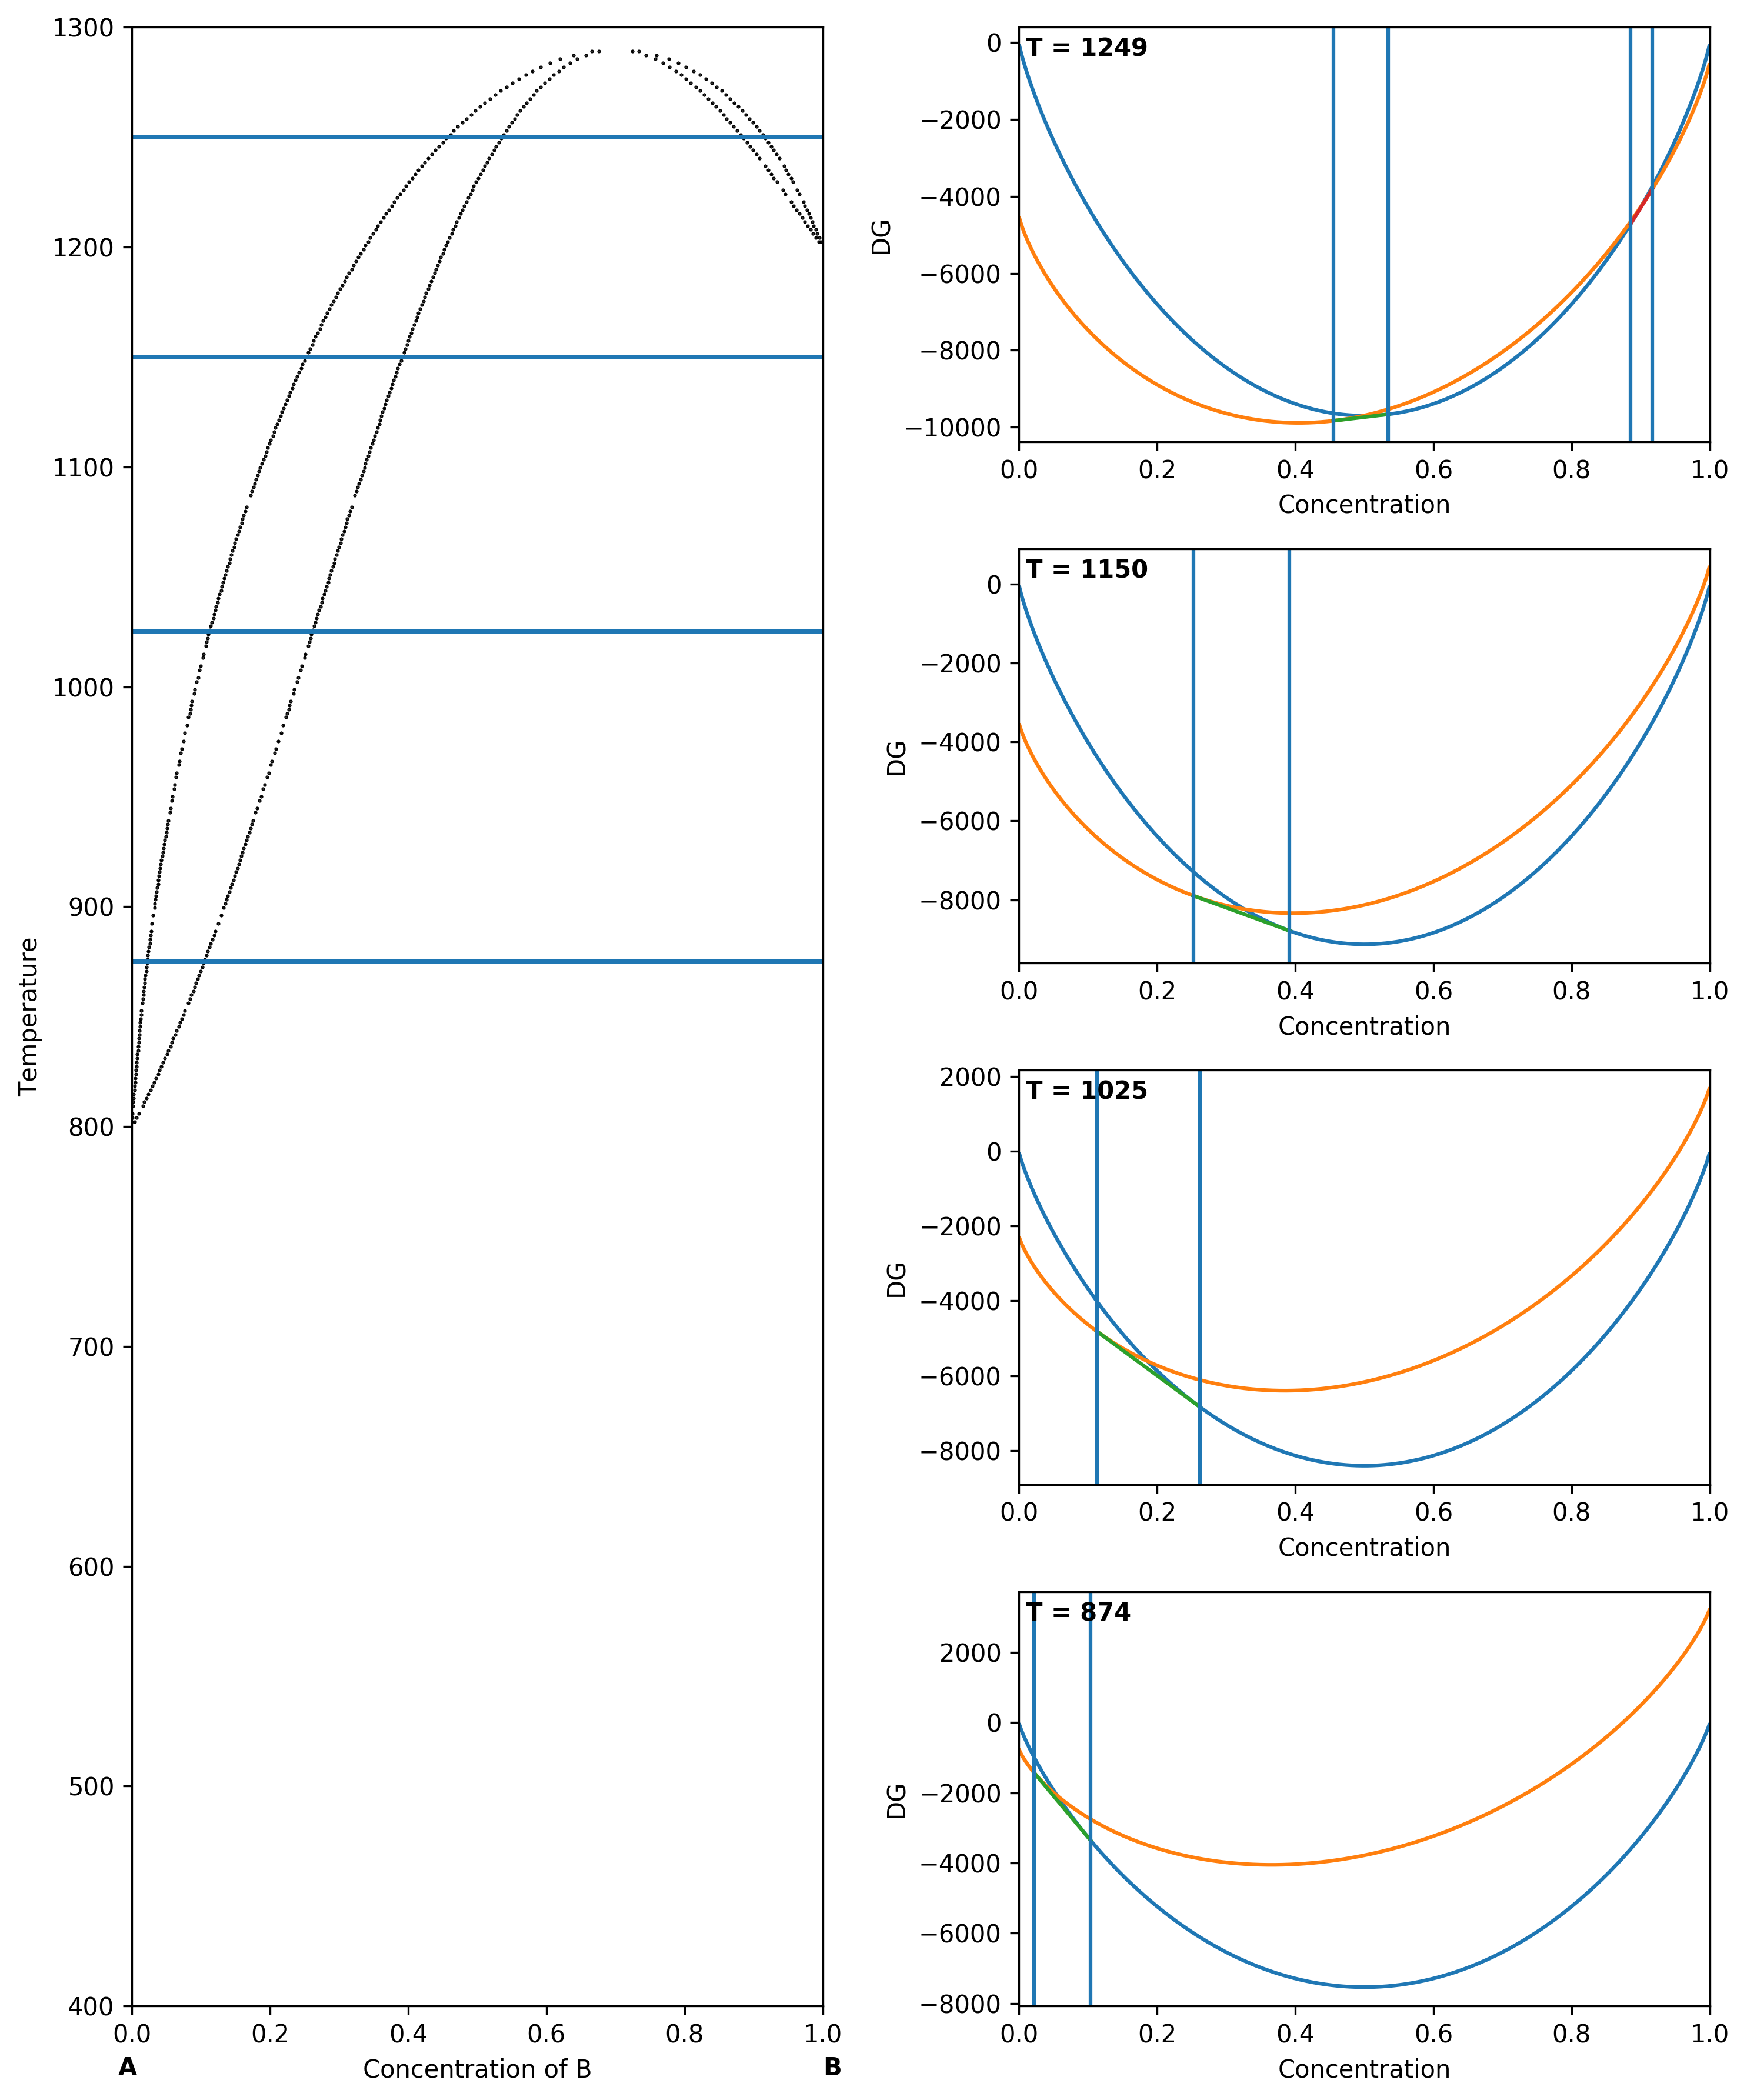

In [5]:
#Parameters
p1ref = [1,1]
guess1 = np.array([0.6,0.5])
guess2 = np.array([0.7,0.8])
Tmin = 400
Tmax = 1300
nT = 500
GTemps = np.array([875,1025,1150,1250])

#Nothing to change below
p2ref = [not p1ref[0],not p1ref[1]]
Tchk = 1.05*(Tmax-Tmin)/(2*nT)
fig=plt.figure(figsize=(10,12), dpi= 300, facecolor='w', edgecolor='k')
guesses = [guess1,guess2]

Tvec = np.linspace(Tmin,Tmax,nT)

#for T in Tvec:
for T in Tvec[len(Tvec)-1:0:-1]: #this is a kludge. Uncomment this line (and comment previous) to build phase diagram from high temps to lower.
    Tarry = []
    Gmin = []
    pts = []
    
    ind = np.where(abs(GTemps - T) < Tchk)[0]
    if len(ind) != 0:
        ax = plt.subplot(len(GTemps),2,2*(len(GTemps)-ind[0]))
        phase1.plotPD(T,p1ref)
        phase2.plotPD(T,p2ref)
        plt.text(0.01, 0.93, 'T = {}'.format(int(T)), fontweight="bold", transform=ax.transAxes)
        
    for i in [0,1]:
        #print('n=',n)
        result = getcomtan(phases[0],phases[1],T,guesses[i],p1ref)
        #print(result)
        if result[3] == 1 and result[0] > 0 and result[0] < 1 and result[1] > 0 and result[1] < 1:
            pt1 = round(result[0],3)
            pt2 = round(result[1],3)
            if (pt1,pt2) not in pts:
                pts.append((pt1,pt2))  
            guesses[i] = np.array([result[0],result[1]])
            
            if len(ind) != 0:
                plt.subplot(len(GTemps),2,2*(len(GTemps)-ind[0]))
                Xval = np.array([result[0],result[1]])
                G1 = GReg(Xval[0],T,phase1.C(),p1ref)
                G2 = GReg(Xval[0],T,phase2.C(),p2ref)
                if G1 < G2:
                    plt.plot(Xval,[G1,GReg(Xval[1],T,phase2.C(),p2ref)])
                else:
                    plt.plot(Xval,[G2,GReg(Xval[1],T,phase1.C(),p1ref)])
                plt.axvline(x=Xval[0])
                plt.axvline(x=Xval[1])
    
    Tarry = ml.repmat(T,2,len(np.array(pts)))
    plt.subplot(1,2,1)
    for Tline in GTemps:
        plt.axhline(y=Tline)
    plt.scatter(pts,Tarry,s=1,c='black',marker='.')

ax = plt.subplot(1,2,1)
plt.text(-0.02, -0.035, 'A', fontweight="bold", transform=ax.transAxes)
plt.text(1., -0.035, 'B', fontweight="bold", transform=ax.transAxes)
plt.xlim([0.,1.])
plt.ylim([Tmin,Tmax])
plt.xlabel('Concentration of B')
plt.ylabel('Temperature')
plt.tight_layout()